In [108]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import logging
import re
import sqlite3
#Définition de constantes
AXE_COLONNES = 1

# Traitement des données sur l'emploi
## Obtention des données

In [109]:
sns.set(rc={'figure.figsize':(20,8.27)})

In [110]:
def separer_numero_departement(valeur):
    valeur_a_comparer = valeur.strip().lower()
    if valeur_a_comparer == "loire atlantique":
       return 44
    elif valeur_a_comparer == "alpes-maritimes":
       return 6

In [111]:
def afficher_noms_colonnes_avec_valeurs_manquantes(dataframe):
  column_labels = list(dataframe.columns)
  for column_label in column_labels:
    if dataframe[column_label].hasnans:
      print(column_label)

In [112]:
sheet_names = ['Emploi LA', 'Emploi Indus LA', 'Tertiaire marchand LA', 'Tertiaire non march LA', 'Chom LA', 'Emploi AM', 'Emploi Indus AM', 'Tertiaire march AM', 'Tertiaire non march AM OK', 'Chom AM']
dict_donnees_insee = pd.read_excel("./data/donnees_insee.xlsx", sheet_name=sheet_names, skiprows=6)
dict_donnees_insee['Tertiaire non march AM OK'] = dict_donnees_insee['Tertiaire non march AM OK'].drop(33, axis=0)

for item in dict_donnees_insee.items():
   dataframe = dict_donnees_insee[item[0]]
   dataframe = dataframe.dropna(axis=0, how="all")
   dict_donnees_insee[item[0]] = dataframe
   #print(item[0], str(dict_donnees_insee[item[0]].shape))
dataframes = dict_donnees_insee.values()
dataset_insee = pd.concat(dataframes, axis=0,keys=sheet_names).reset_index(level=1,drop=True)
dataset_insee.insert(0,"N°_Departement",dataset_insee["Zone_geographique"].apply(separer_numero_departement))
dataset_insee = dataset_insee.drop("Zone_geographique", axis=AXE_COLONNES)
display(dataset_insee)

,N°_Departement,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi LA,44,513549.0,519946.50,521034.5,522314.00,518667,519755.0,521034.5,522122.5,523019.0,...,608047.000000,608497.0,614328.000000,621391.000000,626772.000000,633914.0,637679.000000,640581.000000,643603.000000,645104.0
Emploi Indus LA,44,87440.0,87769.75,88099.5,88429.25,86121,86567.0,87013.0,87459.0,84337.0,...,85414.000000,85526.0,84912.500000,84299.000000,83685.500000,87980.0,87980.000000,87980.000000,87980.000000,NaN
Tertiaire marchand LA,44,290834.0,288973.00,288577.0,288965.00,287697,285539.0,286943.0,284718.0,283144.0,...,257727.000000,257244.0,257796.000000,258723.000000,259970.000000,261487.0,262210.000000,263290.000000,265222.000000,266202.0
Tertiaire non march LA,44,145778.0,146213.50,146649.0,147084.50,147520,148151.5,148783.0,149414.5,150046.0,...,185481.500000,185826.0,186265.500000,186705.000000,187144.500000,187584.0,187742.213883,187742.213883,187742.213883,188216.0
Chom LA,44,6.5,6.40,6.4,6.40,6.5,6.8,6.9,6.8,7.1,...,7.800000,6.9,6.900000,6.600000,6.600000,6.1,5.900000,6.000000,6.000000,5.8
Emploi AM,6,419917.0,421377.75,422838.5,424299.25,425760,427475.5,429191.0,430906.5,432622.0,...,407882.000000,408611.0,409196.000000,415839.000000,420726.000000,426287.0,429011.000000,433844.000000,432781.000000,434185.0
Emploi Indus AM,6,35203.8,35217.40,35246.8,35118.80,34933,34890.2,34942.4,34732.0,34553.2,...,31817.800000,31909.4,32180.000000,32351.400000,32612.600000,32824.2,32973.200000,33107.400000,33271.200000,33505.0
Tertiaire march AM,6,151712.4,153507.00,153934.4,154494.00,154861.4,155220.0,156114.0,156405.2,156726.6,...,179816.000000,178286.8,179505.400000,184554.600000,187511.400000,190263.2,191832.800000,193891.600000,194276.000000,194307.0
Tertiaire non march AM OK,6,121852.0,122561.75,123271.5,123981.25,124691,125509.5,126328.0,127146.5,127965.0,...,147455.535163,148145.0,158616.043261,159007.172189,159362.130132,159910.0,NaN,NaN,NaN,NaN
Chom AM,6,10.2,10.00,9.8,9.60,9.6,9.9,10.0,9.8,10.0,...,10.100000,9.1,9.300000,9.000000,8.900000,8.4,8.300000,8.200000,8.200000,8.0


## Traîtement des données manquantes sur l'emploi

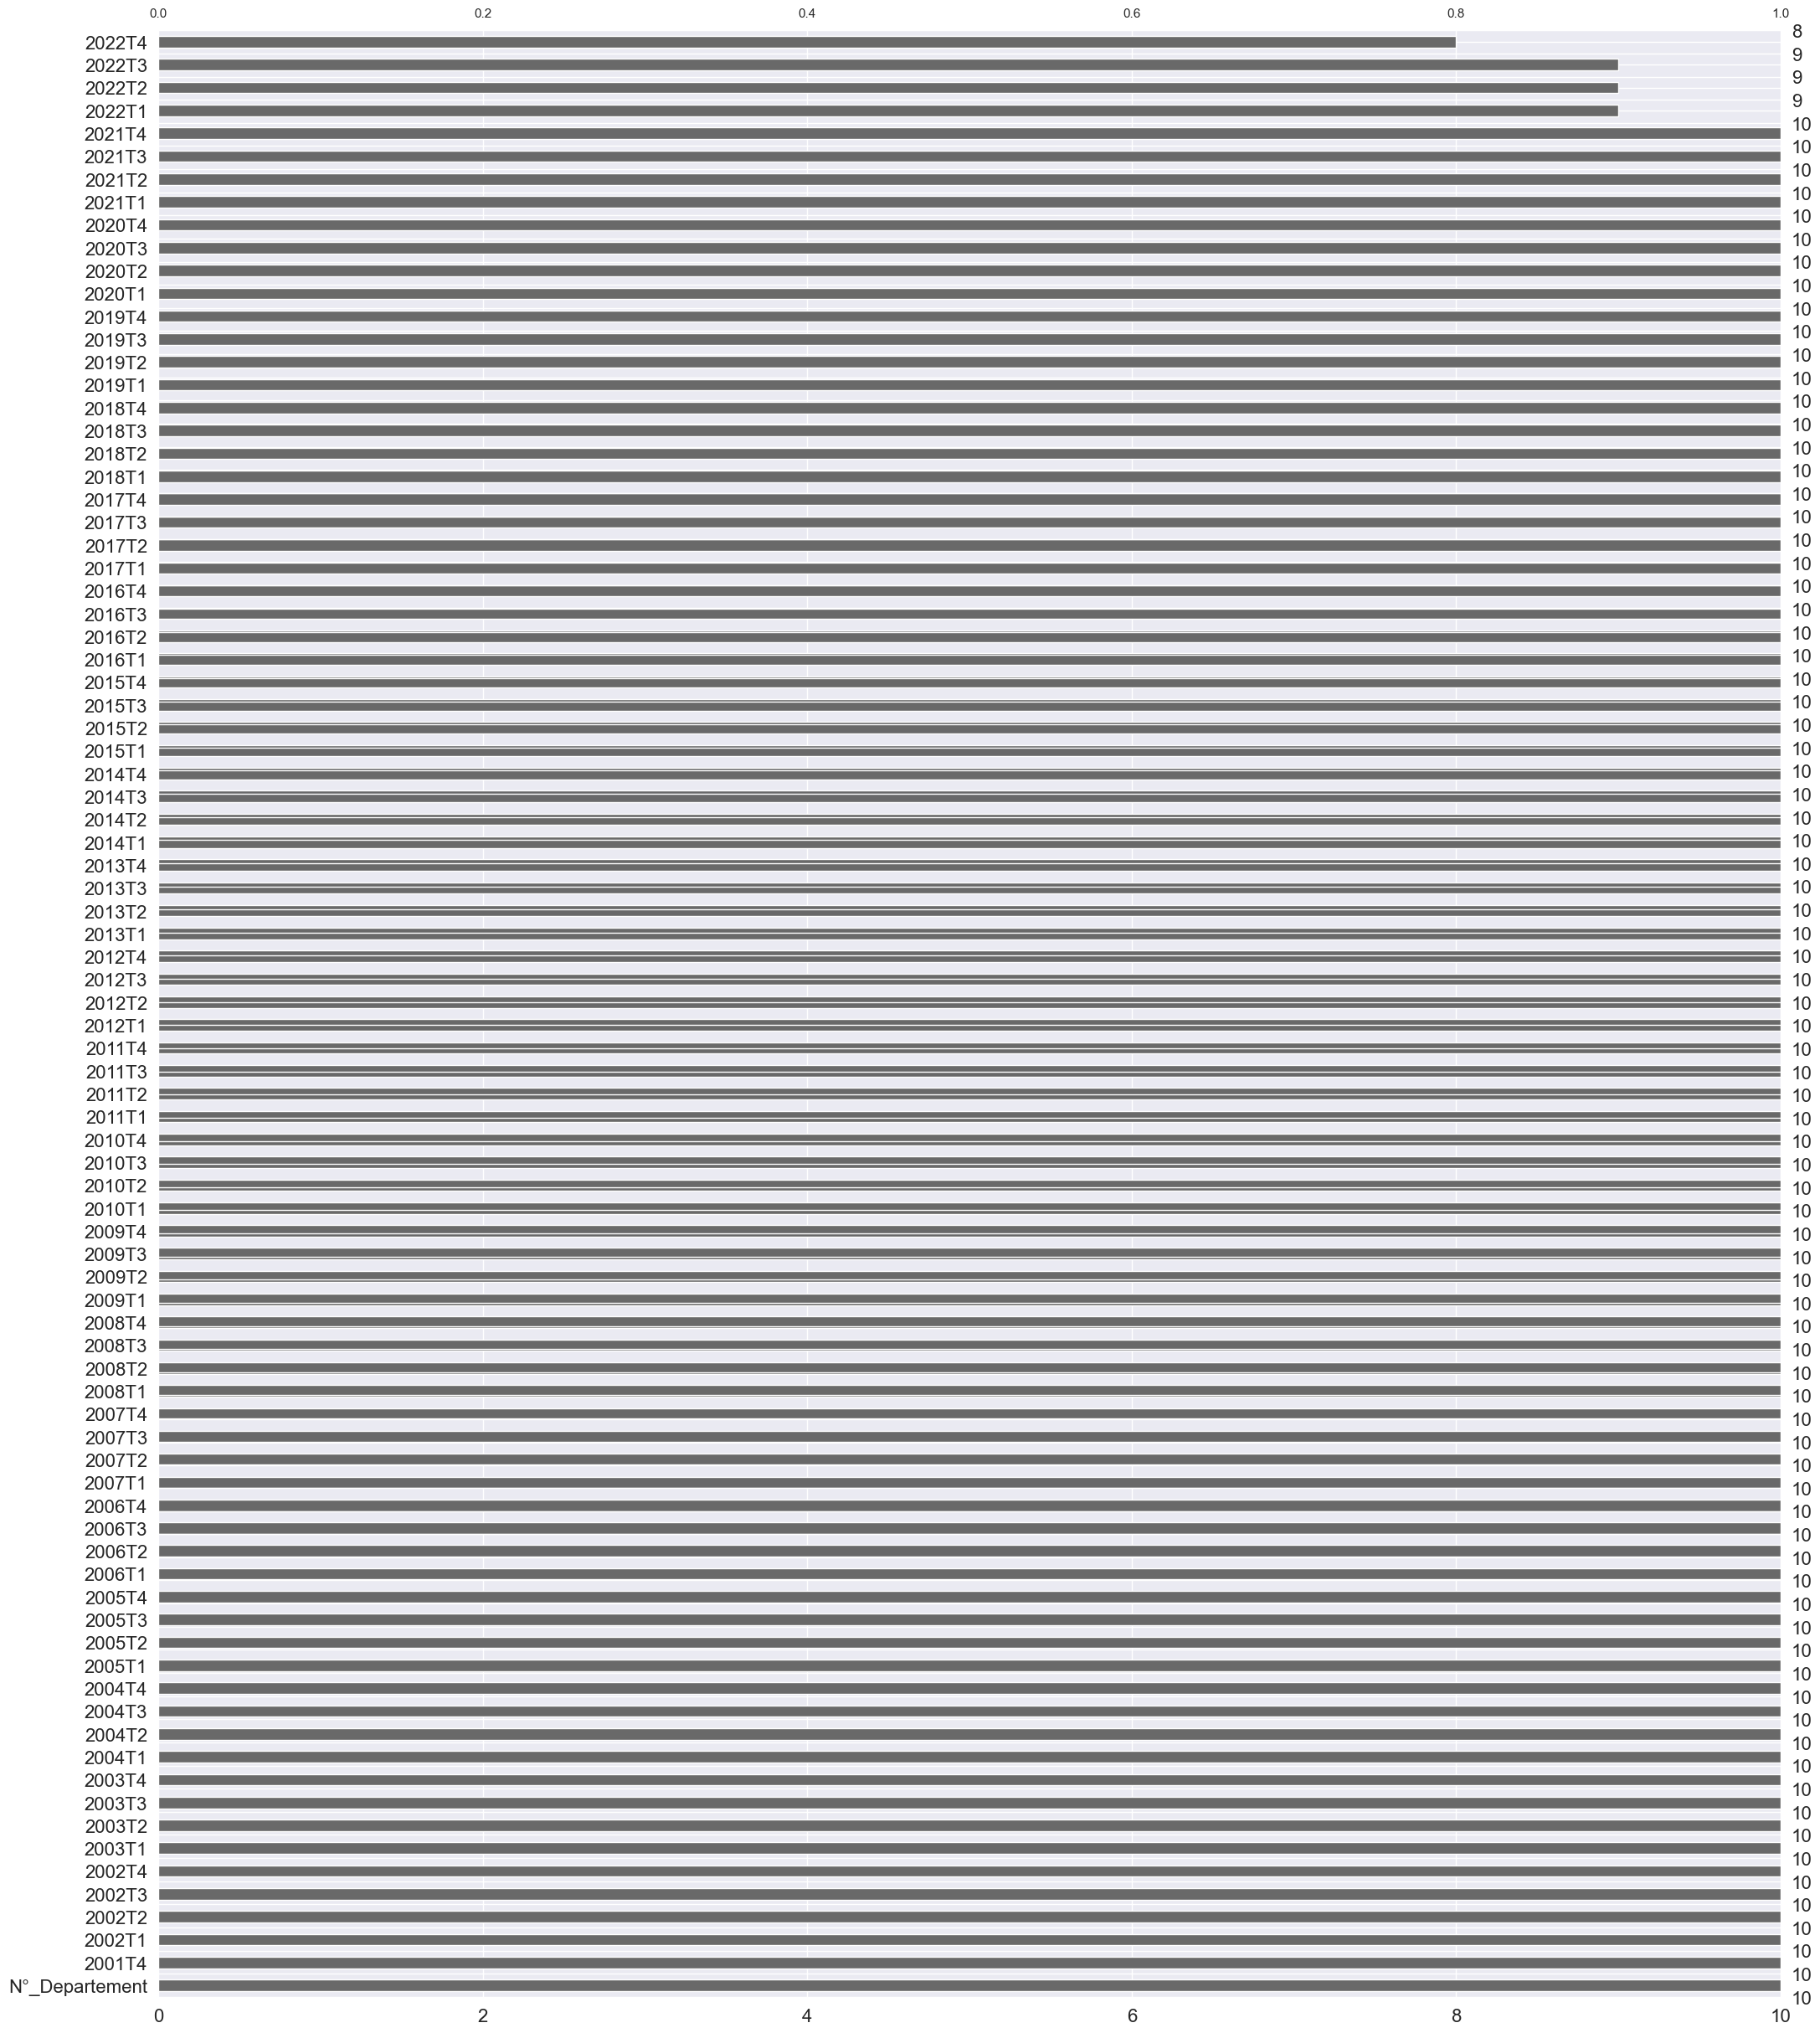

In [113]:
msno.bar(dataset_insee)
plt.savefig("donnees_manquantes_emploi_insee_LA_AM.png")
plt.show()

In [114]:
nan_values_dataframe = dataset_insee.isna()
missing_values_row_indexes = nan_values_dataframe[(nan_values_dataframe["2022T1"] == True)|(nan_values_dataframe["2022T2"] == True)|(nan_values_dataframe["2022T3"].isnull().any() == True)|(nan_values_dataframe["2022T4"] == True)].index
missing_values_row_indexes
rows_w_missing_values = dataset_insee.loc[missing_values_row_indexes]
interesting_columns = [column for column in rows_w_missing_values if "2022" in column]
for column in interesting_columns :
    print("\n"+ column)
    print(rows_w_missing_values[column].isna())


2022T1
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T1, dtype: bool

2022T2
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T2, dtype: bool

2022T3
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T3, dtype: bool

2022T4
Emploi Indus LA              True
Tertiaire non march AM OK    True
Name: 2022T4, dtype: bool


## Régression linéaire sur les séries présentant des données manquantes
### Détermination de la droite de régression linéaire (d'ajustement)

In [115]:
rows_w_missing_values.columns = range(rows_w_missing_values.columns.size)
predicted_y_values_dict = {}
# Régression linéaire sur les données manquantes
previous_data_slice = slice(1,82)
target_slice = slice(82, None)
#Plaçage des features et des labels dans des tableaux à une dimension, Travail avec les données emploi Indus LA
x = rows_w_missing_values.columns[previous_data_slice].to_numpy().reshape(-1,1)
for i in range(len(rows_w_missing_values)):
    current_series_name = rows_w_missing_values.index[i]
    y = rows_w_missing_values.iloc[i,previous_data_slice].to_numpy().reshape(-1,1)
    #Découpage des données en jeux d'entraînement et de test
    #splitted_datasets_tuple = train_test_split(x, y, test_size=0.2, train_size=0.8)
    #Préparation des données à la régression linéaire
    #X_train, X_test, y_train, y_test = map(lambda dataset : dataset.reshape(1,dataset.shape[0]), splitted_datasets_tuple)
    
    regression_model = LinearRegression()
    # Adapter les données (entraînement du modèle)
    regression_model.fit(x,y)
    # Prédiction
    y_predicted = regression_model.predict(x)
    
    predicted_y_values_dict[current_series_name] = y_predicted
    r2 = r2_score(y, y_predicted)
    corr_coef = math.sqrt(r2)
    print(corr_coef)

0.3012612648782639
0.94462803098395


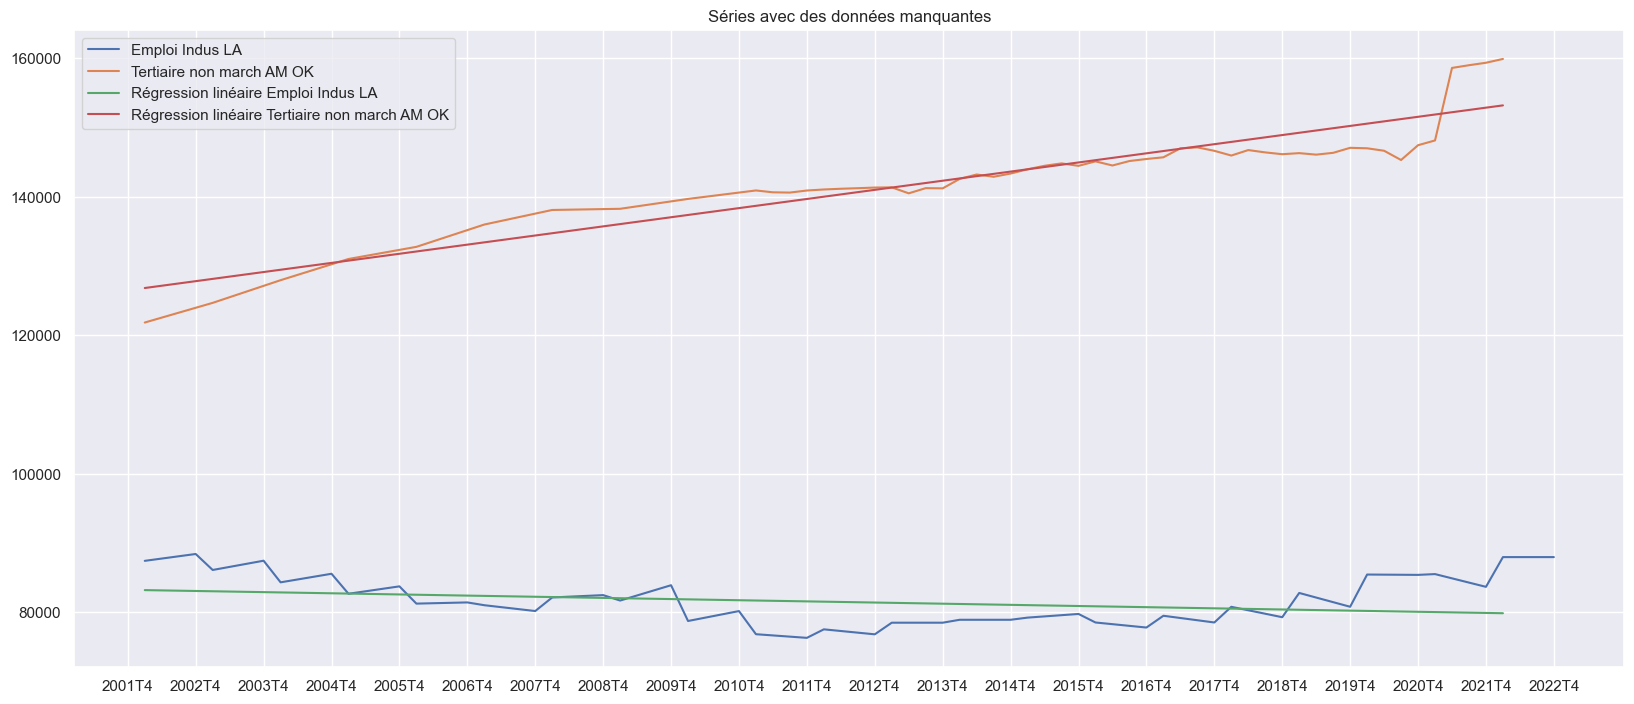

In [116]:
ticks_labels = list(dataset_insee.filter(axis=AXE_COLONNES, regex="\d{4}T4").columns)
x_y_axis_dataframe_slicing = slice(1,None)
title = "Séries avec des données manquantes"
for row_label in rows_w_missing_values.index:
    x = list(rows_w_missing_values.columns)[x_y_axis_dataframe_slicing]
    y = rows_w_missing_values.loc[row_label].iloc[x_y_axis_dataframe_slicing]
    plt.xticks(range(0,85,4),labels=ticks_labels)
    plt.plot(x,y,label=row_label)
for name,value in predicted_y_values_dict.items():
    plt.plot(x[0:81], value, label="Régression linéaire " + name)
plt.title(title)
plt.legend()
plt.savefig(title + ".png")
plt.show()

### Analyse des résidus

## Affichage de graphiques décrivant les données

In [117]:
dataset_insee_44 = dataset_insee[dataset_insee["N°_Departement"] == 44]
dataset_insee_44

,N°_Departement,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi LA,44,513549.0,519946.50,521034.5,522314.00,518667,519755.0,521034.5,522122.5,523019.0,...,608047.0,608497.0,614328.0,621391.0,626772.0,633914.0,637679.000000,640581.000000,643603.000000,645104.0
Emploi Indus LA,44,87440.0,87769.75,88099.5,88429.25,86121,86567.0,87013.0,87459.0,84337.0,...,85414.0,85526.0,84912.5,84299.0,83685.5,87980.0,87980.000000,87980.000000,87980.000000,NaN
Tertiaire marchand LA,44,290834.0,288973.00,288577.0,288965.00,287697,285539.0,286943.0,284718.0,283144.0,...,257727.0,257244.0,257796.0,258723.0,259970.0,261487.0,262210.000000,263290.000000,265222.000000,266202.0
Tertiaire non march LA,44,145778.0,146213.50,146649.0,147084.50,147520,148151.5,148783.0,149414.5,150046.0,...,185481.5,185826.0,186265.5,186705.0,187144.5,187584.0,187742.213883,187742.213883,187742.213883,188216.0
Chom LA,44,6.5,6.40,6.4,6.40,6.5,6.8,6.9,6.8,7.1,...,7.8,6.9,6.9,6.6,6.6,6.1,5.900000,6.000000,6.000000,5.8


In [118]:
dataset_insee_06 = dataset_insee[dataset_insee["N°_Departement"] == 6]
dataset_insee_06

,N°_Departement,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi AM,6,419917.0,421377.75,422838.5,424299.25,425760,427475.5,429191.0,430906.5,432622.0,...,407882.000000,408611.0,409196.000000,415839.000000,420726.000000,426287.0,429011.0,433844.0,432781.0,434185.0
Emploi Indus AM,6,35203.8,35217.40,35246.8,35118.80,34933,34890.2,34942.4,34732.0,34553.2,...,31817.800000,31909.4,32180.000000,32351.400000,32612.600000,32824.2,32973.2,33107.4,33271.2,33505.0
Tertiaire march AM,6,151712.4,153507.00,153934.4,154494.00,154861.4,155220.0,156114.0,156405.2,156726.6,...,179816.000000,178286.8,179505.400000,184554.600000,187511.400000,190263.2,191832.8,193891.6,194276.0,194307.0
Tertiaire non march AM OK,6,121852.0,122561.75,123271.5,123981.25,124691,125509.5,126328.0,127146.5,127965.0,...,147455.535163,148145.0,158616.043261,159007.172189,159362.130132,159910.0,NaN,NaN,NaN,NaN
Chom AM,6,10.2,10.00,9.8,9.60,9.6,9.9,10.0,9.8,10.0,...,10.100000,9.1,9.300000,9.000000,8.900000,8.4,8.3,8.2,8.2,8.0


In [119]:
chomage_LA = dataset_insee_44.loc['Chom LA'].iloc[1:]
chomage_LA

2001T4    6.5
2002T1    6.4
2002T2    6.4
2002T3    6.4
2002T4    6.5
         ... 
2021T4    6.1
2022T1    5.9
2022T2    6.0
2022T3    6.0
2022T4    5.8
Name: Chom LA, Length: 85, dtype: object

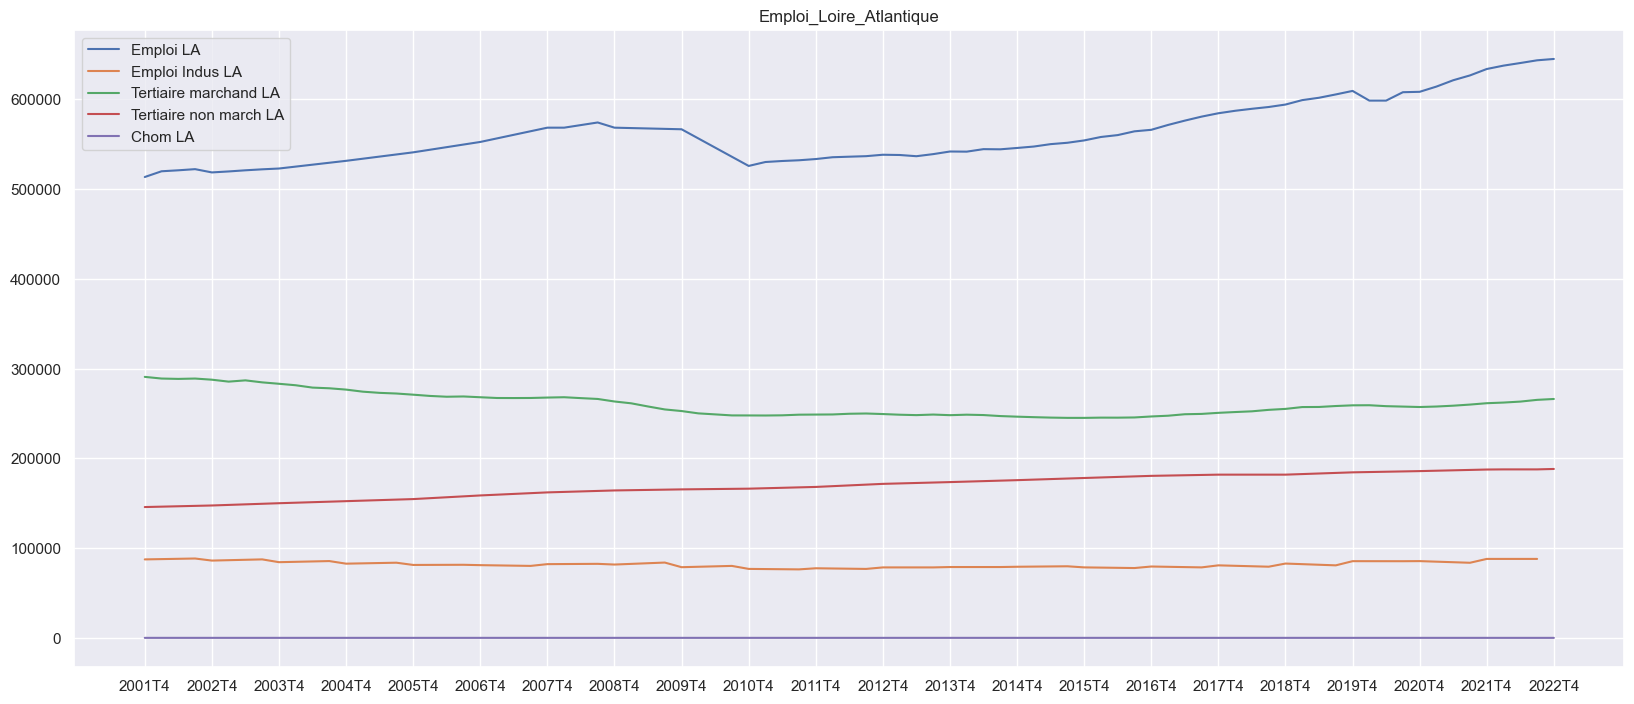

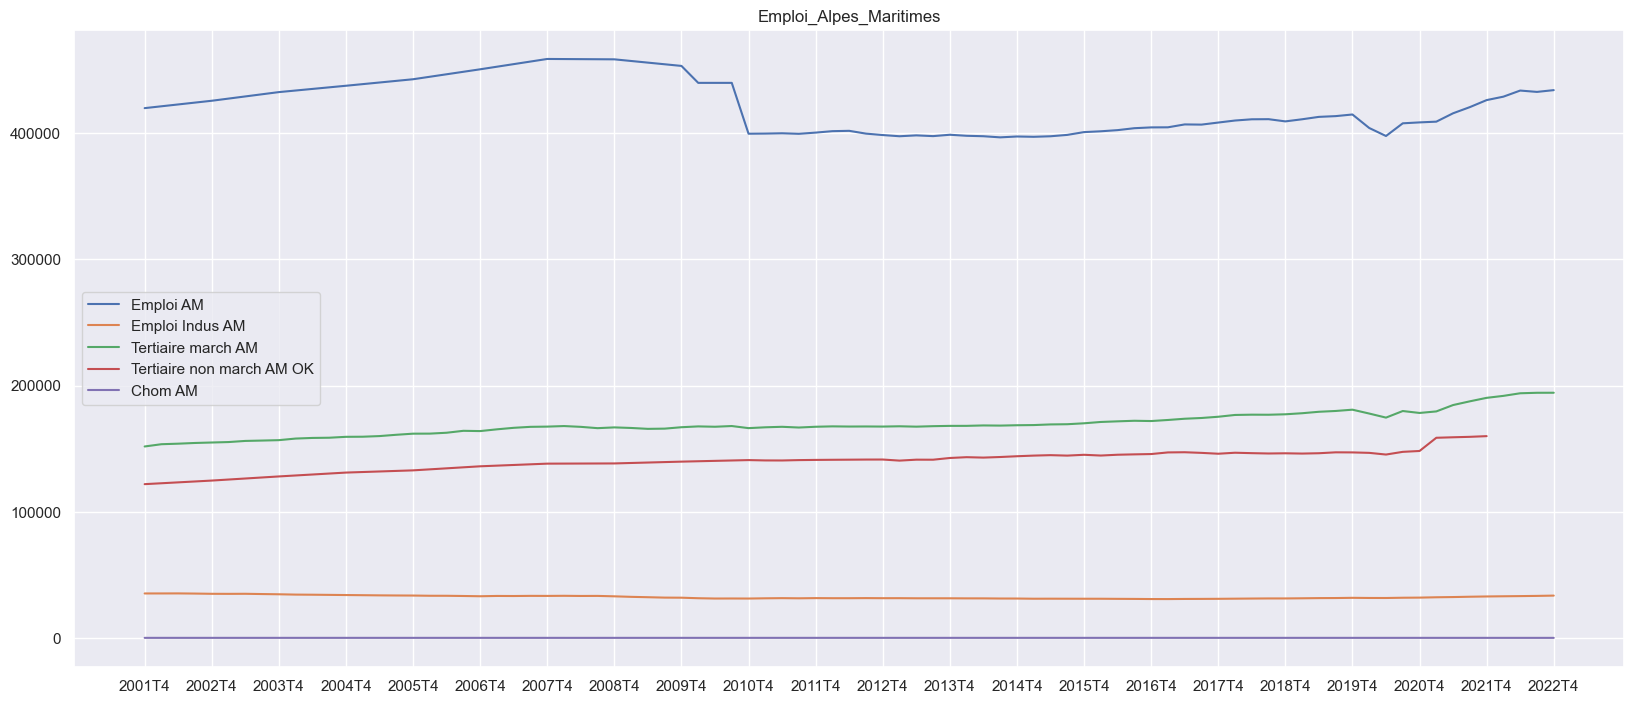

In [120]:
dataframes = [dataset_insee_44, dataset_insee_06]
x_y_axis_dataframe_slicing = slice(1,None)
ticks_labels = list(dataset_insee.filter(axis=AXE_COLONNES, regex="\d{4}T4").columns)
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    departement = "Loire_Atlantique" if i == 0 else "Alpes_Maritimes"
    title = "Emploi_" + departement
    for row_label in dataframe.index:
        x = list(dataframe.columns)[x_y_axis_dataframe_slicing]
        y = dataframe.loc[row_label].iloc[x_y_axis_dataframe_slicing]
        plt.xticks(range(0,85,4),labels=ticks_labels)
        plt.plot(x,y,label=row_label)
    plt.title(title)
    plt.legend()
    plt.savefig(title + ".png")
    plt.show()

In [121]:
proportions = []
for i in range(len(dataframes)) :
    zone = "LA" if i == 0 else "AM"
    libelle_colonne_emploi = "Emploi {}".format(zone)
    libelle_colonne_num_departement = "N°_Departement"
    dataframe = dataframes[i].drop(libelle_colonne_num_departement, axis=AXE_COLONNES)
    display(afficher_noms_colonnes_avec_valeurs_manquantes(dataframe))
    libelles_lignes_emploi_et_chomage = [libelle_colonne_emploi,"Chom {}".format(zone)]
    serie_emploi_total = dataframe.loc[libelle_colonne_emploi]
    dataframe_sans_emploi_total_ni_chomage = dataframe.drop(libelles_lignes_emploi_et_chomage, axis=0)
    proportion_emploi_par_secteur = dataframe_sans_emploi_total_ni_chomage.divide(serie_emploi_total).mul(100)
    display(proportion_emploi_par_secteur)
    display(proportion_emploi_par_secteur.sum(axis=0))
    proportions.append(proportion_emploi_par_secteur)

2022T4


None

,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,2004T1,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi Indus LA,17.026613,16.880535,16.908573,16.930285,16.604295,16.655347,16.700046,16.750667,16.125036,16.137844,...,14.047269,14.055287,13.822014,13.566177,13.351825,13.878854,13.79691,13.734407,13.669918,NaN
Tertiaire marchand LA,56.632181,55.577449,55.385392,55.324001,55.468538,54.93723,55.071785,54.530881,54.136465,53.601569,...,42.386033,42.275311,41.963902,41.636104,41.477603,41.249602,41.119435,41.10175,41.208944,41.264974
Tertiaire non march LA,28.386386,28.120874,28.145737,28.160168,28.442141,28.504103,28.555307,28.616752,28.688442,28.680402,...,30.504468,30.538524,30.320204,30.046299,29.858465,29.591396,29.441492,29.308115,29.1705,29.176071


2001T4     102.04518
2002T1    100.578858
2002T2    100.439702
2002T3    100.414454
2002T4    100.514974
             ...    
2021T4     84.719852
2022T1     84.357837
2022T2     84.144271
2022T3     84.049362
2022T4     70.441045
Length: 85, dtype: object

2022T1
2022T2
2022T3
2022T4


None

,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,2004T1,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi Indus AM,8.383514,8.357679,8.335759,8.276894,8.204857,8.161918,8.141457,8.060217,7.986926,7.904812,...,7.800736,7.809237,7.864202,7.77979,7.751506,7.700024,7.685864,7.631176,7.687768,7.716757
Tertiaire march AM,36.12914,36.429783,36.40501,36.411566,36.372933,36.310853,36.374015,36.296784,36.227145,36.413064,...,44.085299,43.632403,43.867829,44.381263,44.568532,44.632654,44.715124,44.691548,44.890141,44.752122
Tertiaire non march AM OK,29.018115,29.085957,29.153329,29.220238,29.286687,29.36063,29.433982,29.506749,29.57894,29.669609,...,36.151518,36.255754,38.762853,38.237677,37.87789,37.512286,NaN,NaN,NaN,NaN


2001T4    73.530769
2002T1    73.873419
2002T2    73.894099
2002T3    73.908698
2002T4    73.864478
            ...    
2021T4    89.844964
2022T1    52.400987
2022T2    52.322724
2022T3    52.577909
2022T4    52.468878
Length: 85, dtype: object

In [122]:
trimestres_interessants = ["2007T2","2012T2","2017T2","2022T2"]
dataset_insee_proportions_emploi_AM = proportions[1]
proportions_donnees_elections_AM = dataset_insee_proportions_emploi_AM[trimestres_interessants]
proportions_donnees_elections_AM

,2007T2,2012T2,2017T2,2022T2
Emploi Indus AM,7.294463,7.822623,7.58022,7.631176
Tertiaire march AM,36.6104,41.678327,42.678106,44.691548
Tertiaire non march AM OK,30.134873,35.14279,36.153002,NaN


TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

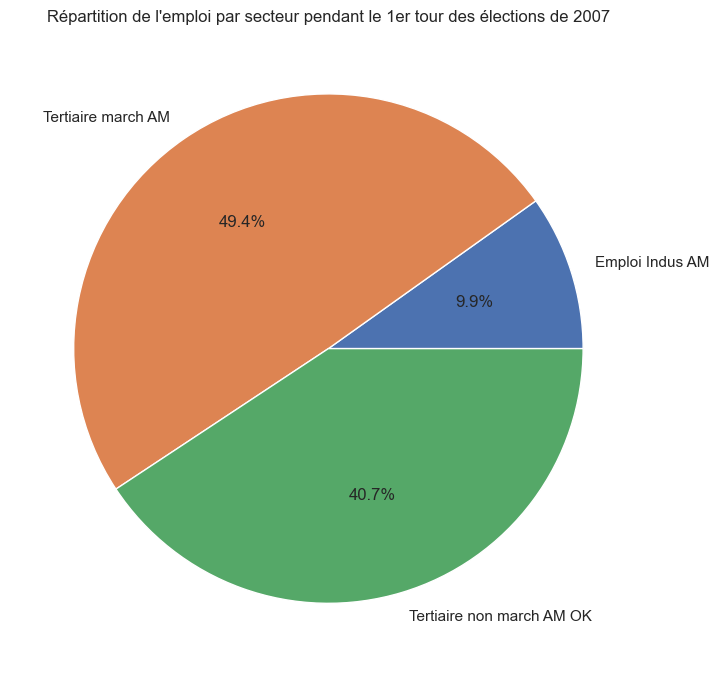

In [123]:
labels = proportions_donnees_elections_AM.index
for column in proportions_donnees_elections_AM.columns:
    title = 'Répartition de l\'emploi par secteur pendant le 1er tour des élections de {}'.format(column[0:4])
    fig, ax = plt.subplots()
    plt.title(title)
    ax.pie(proportions_donnees_elections_AM[column], labels=labels, autopct='%1.1f%%')
    plt.savefig()

## Traitement des données sur la sécurité

In [ ]:
donnes_securite_dept = pd.read_csv("./data/donnee-securité.csv",
                                   sep=';')
# Filtrer les données de sécurité sur l'année 2022 et sur les départements 44 et 06
donnees_securite_44_06 = donnes_securite_dept[
 (donnes_securite_dept['Code.département'] == '6') | (donnes_securite_dept['Code.département'] == '06') | (
                donnes_securite_dept['Code.département'] == '44')]

nb_faits_par_departements = donnees_securite_2022_44_06.groupby('Code.département').sum()['faits']

donnees_securite_44_06

